In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import math
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tcl

2024-04-28 10:44:47.242543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 10:44:47.743577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes = [
  "T-shirt/top",
  "Trouser",
  "Pullover",
  "Dress",
  "Coat",
  "Sandal",
  "Shirt",
  "Sneaker",
  "Bag",
  "Ankle boot",
]

In [3]:
ds = tfds.load("huggingface:fashion_mnist", split="all", as_supervised=True, data_dir="/drive")

/usr/local/lib/python3.11/dist-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:160: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()
2024-04-28 10:45:30.975012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 10:45:31.039190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 10:45:31.039230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA supp

In [14]:
DIM = 28
CH = 3
BATCH = 32
model = tf.keras.Sequential([
    tfl.Input(shape=(DIM, DIM, CH), batch_size=BATCH),

    tfl.Conv2D(32, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.Conv2D(32, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    tfl.Dropout(0.2),

    tfl.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    tfl.Dropout(0.3),

    tfl.Conv2D(128, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.Conv2D(128, (3, 3), activation='relu', padding="same"),
    tfl.BatchNormalization(),
    tfl.MaxPooling2D((2, 2)),
    tfl.Dropout(0.4),

    tfl.Flatten(),
    tfl.Dense(128, activation='relu'),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),

    tfl.Dense(10, activation='softmax') # 10 classes, probability
])

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['sparse_categorical_accuracy'])

In [16]:
augmentation = tf.keras.Sequential([
    # tfl.RandomFlip("horizontal_and_vertical"),
    tfl.RandomRotation(0.2),
])

In [17]:
dsCount = len(ds)
trainCount = math.floor(0.8*dsCount)
testCount = math.floor(0.1*dsCount)
validateCount = dsCount - trainCount - testCount
ds = ds.shuffle(32)
train = ds.take(trainCount)
test = ds.skip(trainCount).take(testCount)
validate = ds.skip(trainCount+testCount).take(validateCount)
print(f"Training: {len(train)}\nTesting: {len(test)}\nValidation: {len(validate)}")

Training: 56000
Testing: 7000
Validation: 7000


In [18]:
def normalize(img, label):
  image = tf.cast(img, tf.float32) / 255.
  return (image, label)

train = train\
.map(normalize)\
.cache()\
.shuffle(buffer_size=BATCH)\
.batch(BATCH, drop_remainder=True)\
.map(lambda img, label: (augmentation(img, training=True), label), num_parallel_calls=tf.data.AUTOTUNE)\
.prefetch(tf.data.AUTOTUNE)

test = test\
.map(normalize)\
.cache()\
.batch(BATCH, drop_remainder=True)\
.prefetch(tf.data.AUTOTUNE)

In [19]:
early_stopping = tcl.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tcl.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
history = model.fit(train, epochs = 50, validation_data = test, callbacks=[early_stopping, reduce_lr], batch_size=BATCH)

Epoch 1/50


2024-04-28 10:47:24.705435: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


   6/1750 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - loss: 3.2696 - sparse_categorical_accuracy: 0.0829  

I0000 00:00:1714301253.273686    5643 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2991 - sparse_categorical_accuracy: 0.5690

2024-04-28 10:47:45.200407: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 1.2984 - sparse_categorical_accuracy: 0.5693 - val_loss: 0.5846 - val_sparse_categorical_accuracy: 0.7894 - learning_rate: 0.0010
Epoch 2/50


2024-04-28 10:47:50.435552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.6530 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.5205 - val_sparse_categorical_accuracy: 0.8032 - learning_rate: 0.0010
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.5524 - sparse_categorical_accuracy: 0.8021 - val_loss: 0.4392 - val_sparse_categorical_accuracy: 0.8362 - learning_rate: 0.0010
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.4929 - sparse_categorical_accuracy: 0.8256 - val_loss: 0.3453 - val_sparse_categorical_accuracy: 0.8694 - learning_rate: 0.0010
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.4595 - sparse_categorical_accuracy: 0.8369 - val_loss: 0.3456 - val_sparse_categorical_accuracy: 0.8713 - learning_rate: 0.0010
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.4323 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.3432 - val_sparse_categorical_accuracy: 0.8757 - learning_rate: 0.0010
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 5

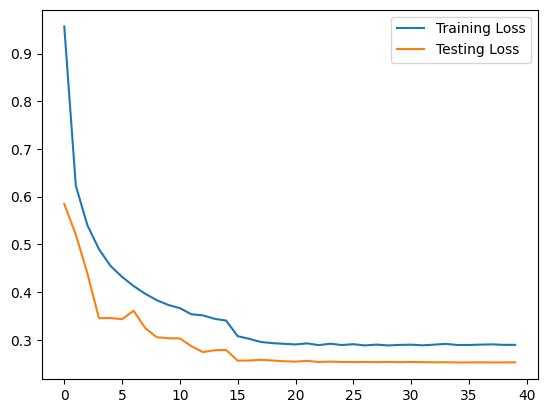

In [20]:
h=history.history
plt.plot(h["loss"], label="Training Loss")
plt.plot(h["val_loss"], label="Testing Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

2024-04-28 11:23:41.197688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


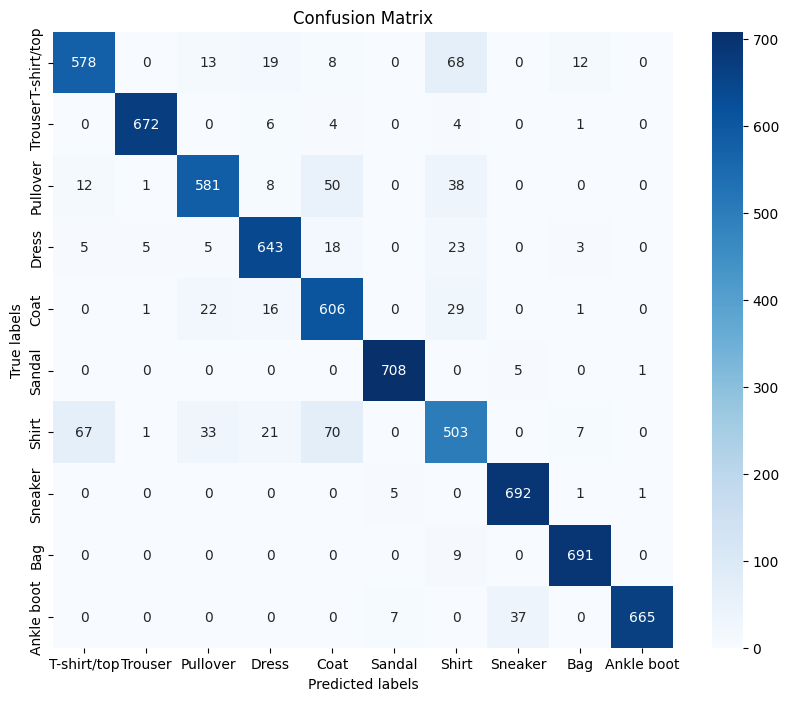

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       698
           1       0.99      0.98      0.98       687
           2       0.89      0.84      0.86       690
           3       0.90      0.92      0.91       702
           4       0.80      0.90      0.85       675
           5       0.98      0.99      0.99       714
           6       0.75      0.72      0.73       702
           7       0.94      0.99      0.97       699
           8       0.97      0.99      0.98       700
           9       1.00      0.94      0.97       709

    accuracy                           0.91      6976
   macro avg       0.91      0.91      0.91      6976
weighted avg       0.91      0.91      0.91      6976



In [105]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ds = validate.map(normalize).batch(BATCH,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

y_true = []
y_pred = []

for images, labels in ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred))